# Notebook Overview

## Goals

- Data Splitting
    - Split data into training and testing samples
- Modeling
    - Define the structure of the model using LSTM
- Training
    - Train the model using the encoded Yelp data
- Evaluation
    - Evvaluate the performance of the model

## Data

### Processed

- Derived from Yelp review dataset (https://www.yelp.com/dataset)
- Generated in previous notebook, accessible from kaggle as `yelp-dataset-reviews-encoded` (https://www.kaggle.com/datasets/gabrielmadigan/yelp-dataset-reviews-encoded)
- Specifically, I analyze the `/data/proc/encoded-data.json` file which has been prepared for model training and testing following inspection, cleaning, reduction, tokenization, lemmatization, and numerical encoding of the raw Yelp dataset (see below).

### Interim

- Derived from Yelp review dataset (https://www.yelp.com/dataset)
- Generated in previous notebook, accessible from kaggle as `yelp-dataset-reviews-nlp` (https://www.kaggle.com/datasets/gabrielmadigan/yelp-dataset-reviews-nlp)
- Specifically, I analyze the `/data/interim/lemmatized-data.json` file which has been prepared for this module following inspection, cleaning, reduction, tokenization, and lemmatization of the raw Yelp dataset (see below).

### Raw

- Yelp review dataset (https://www.yelp.com/dataset)
- Accessible from kaggle as `yelp-dataset` (https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset)
- Description from the kaggle dataset page:
> This dataset is a subset of Yelp's businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp's data and share their discoveries. In the most recent dataset you'll find information about businesses across 8 metropolitan areas in the USA and Canada.
- Specifically, I analyze the `yelp_academic_dataset_review.json` file which contains data pertaining to Yelp user reviews and includes the text of the review and an associated 1-5 star rating of the Yelp user's experience (among other data, e.g., date, business ID, etc.)

## Libraries

- `NumPy` - a fundamental Python package for perfroming scientific analysis and computation, used to transform data (https://numpy.org/)
- `Pandas` - used to read, load, store, inspect, process, and save the data (https://pandas.pydata.org/)
- `Keras` - powerful library for training deep learning models used to train the classifier (https://keras.io/)

## Output
- `/kaggle/working/models/model_checkpoint_epochXX.keras` - trained models where XX is the number of epochs the model was trained over
- `/kaggle/working/figures/train-val-accuracy.pdf` - plot showing model accuracy after each training epoch
- `/kaggle/working/figures/train-val-loss.pdf` - plot showing model loss after each training epoch
- `/kaggle/working/figures/sentiment-predictions.pdf` - plots comparing true labels with predicted sentiment using best model
- `/kaggle/working/figures/confusion-matrix.pdf` - confusion matrix using best model on testing data
- `/kaggle/working/figures/word-cloud.pdf` - word clouds generated from training and texting corpi 

# Environment Setup

- I use `numpy` to pass data as `ndarray` objects to our model
- I will be importing `pandas` to read, load, and handle the data
- For plotting during evaluation I'll make use of the `matplotlib` and `seaborn` libraries
- The `wordcloud` library will allow us to construct a word cloud from the review text for each predicted class for validation
- I only import `sklearn` to split the data into training and testing sets
- The `keras` library will be used to build, train, and evaluate the classifier
- The `tqdm` package is useful for displaying progress bars while processing data (https://tqdm.github.io/)
- The module from `IPython` ensures every command in a cell is displayed, which saves me from having to write lots of print statements.

In [1]:
# Libraries for reading, handling, manipulating and visualizing data
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

# keras modules for training and evaluating neural networks
import keras
from keras import Sequential, Input, metrics
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint

# Settings for displaying commands in a cell
from IPython.core.interactiveshell import InteractiveShell

- We can ignore the warning above
- Some settings for the notebook that aid with analysis

In [2]:
# Display output of every command in a cell
InteractiveShell.ast_node_interactivity = 'all'

# Plot aesthetics
sns.set_style('darkgrid')
my_palette = ['#D62828','#003049','#1B998B','#F77F00','#FCBF49','#EAE2B7','#6E9075','#EFBDEB','#F0F757','#777DA7']
sns.set_palette(my_palette, n_colors=10)

# Read Data

- We will read in two files: the encoded data from the `yelp-dataset-reviews-encoded` dataset and the lemmatized data from `yelp-dataset-reviews-nlp` dataset
- The former contains the encoded data needed for training and evaluating the model
- The latter is only used to help sanity-check the performance of the model

In [3]:
INPUT_PATH = '/kaggle/input/yelp-dataset-reviews-encoded/data/proc/'
INPUT_INT_PATH = '/kaggle/input/yelp-dataset-reviews-nlp/data/interim/'
OUT_PATH = '/kaggle/working/'

# Save all figures to this directory
FIGURE_PATH = os.path.join(OUT_PATH, 'figures')
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)
    
# Save all models to this directory
MODEL_PATH = os.path.join(OUT_PATH, 'models')
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# Read and load the encoded Yelp review data as a pandas dataframe
df_encoded = pd.read_json(os.path.join(INPUT_PATH,'encoded-data.json'), lines=True)

#  Read and load the lemmatized Yelp review data as a pandas dataframe
df_lemmatized = pd.read_json(os.path.join(INPUT_INT_PATH,'lemmatized-data.json'), lines=True)

# Combine the two dataframes
df = pd.concat([df_lemmatized, df_encoded], axis=1)

# Let's also add a label column to our df
df['label'] = np.where(df['stars'] <= 3, 'negative', 'positive')

# Inspect the size and data-types of the df
df.info()

# Inspect the first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   stars            20000 non-null  int64 
 1   lemmatized_text  20000 non-null  object
 2   word_embeddings  20000 non-null  object
 3   onehot_label     20000 non-null  object
 4   label            20000 non-null  object
dtypes: int64(1), object(4)
memory usage: 781.4+ KB


,stars,lemmatized_text,word_embeddings,onehot_label,label
0,3,"[decide, eat, aware, go, about 2 hour, begin, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative
1,5,"[take, lot, spin, class, the year, compare, cl...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive
2,3,"[family, diner, buffet, eclectic, assortment, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative
3,5,"[wow, yummy, different, delicious, favorite, l...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive
4,4,"[cute, interior, owner, give, tour, upcoming, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive


- The dataset correctly contains 20k entries
- The data have been processed (cleaning, subsampling, tokenization, etc.)
- Text data have been lemmatized and encoded as sequences (uniform in length) of word embeddings
- Labels have been one-hot encoded corresponding to "positive" (4-5 stars) and "negative" (1-3 stars) sentiment

# Data Splitting

- Prior to training, we split the data into two sets: a training set and a testing set
- The training set will of course be passed to the model during training (where the weights will be updated)
- The testing set will be passed to the model while in a frozen state, without updating the weights, to asses the performance of the trained model on new data
- The split will be 8/2 training/testing
- We will also shuffle the data, but using a seed value to guarentee reproducibility

In [4]:
TEST_SPLIT = 0.2
RANDOM_SEED = 0
df_train, df_test = train_test_split(df, test_size=TEST_SPLIT, shuffle=True, random_state=RANDOM_SEED)

df_train.head()
df_test.head()

,stars,lemmatized_text,word_embeddings,onehot_label,label
17815,5,"[come, California, hard, find, authentic, mexi...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive
18370,5,"[amazing, bit, emergency, need, lot, work, spi...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive
1379,4,"[look, different, area, highly, recommend, Glo...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive
14763,5,"[great, experience, walk, order, food, take, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive
7346,3,"[service, horrible, man, eye, contact, take, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative


,stars,lemmatized_text,word_embeddings,onehot_label,label
19134,3,"[food, consistent, try, OSFs, WA, good, reason...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative
4981,4,"[Bailey, range, great, product, Mr., Bailey, c...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive
16643,1,"[slow, pharmacy, see, line, 6, 7, deep, pick, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative
19117,2,"[Philly, participate, recent, Philadelphia Mar...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative
5306,4,"[fun, Friday, night, come, Saturday, bartender...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive


- Keras requires us to pass the data as numpy arrays rather than pandas dataframes, so let's create numpy arrays for our input and label data
- N.B. The data will remain in their shuffled order, which ensures that we can merge the model outputs back into our original shuffled dataframes for evaluation

In [5]:
# Convert encoded inputs and labels from pandas series to numpy arrays for training/evaluation
train_input = np.stack(df_train['word_embeddings'].values)
train_labels = np.stack(df_train['onehot_label'].values)
test_input = np.stack(df_test['word_embeddings'].values)
test_labels = np.stack(df_test['onehot_label'].values)

# Inspect the numpy arrays
print('Training set')
print('input data')
train_input.dtype
train_input.shape

print('label data')
train_labels.dtype
train_labels.shape

print('Testing set')
print('input data:')
test_input.dtype
test_input.shape

print('label data:')
test_labels.dtype
test_labels.shape

Training set
input data


dtype('float64')

(16000, 150, 100)

label data


dtype('float64')

(16000, 2)

Testing set
input data:


dtype('float64')

(4000, 150, 100)

label data:


dtype('float64')

(4000, 2)

# Model Training

- Now we are ready to build our model
- We will use a type of Recurrent Neural Network (RNN) called Long Short Term Memory (LSTM)
- LSTM solves the exploding/vanishing gradient problem seen in vanilla RNNs by tracking long-term memory and short-term memory in parallel, where long-term memory does not get operated on by any weights that might cause it to explode/vanish when performing backpropagation
- Before we can build our model, we need to set some of the fixed parameters that define our model

In [6]:
BATCH_SIZE = 32 # samples in each batch during training and evaluation
EMBEDDING_DIM = 100 # dimension of each word embedding
SEQUENCE_LENGTH = 150 # length of padded sequences of word embeddings
NUM_CLASSES = 2 # number of class labels for one-hot encoding
LSTM_LAYERS = 100 # number of recurrent layers in the LSTM RNN

- Now we can construct our model using a LSTM network
- We start with a `Sequential` object imported from the Keras library
- Then we add our input dimensions using the parameters we defined
- Next, add the LSTM network, specifying the number of recurrent layers
- Finally, we need to map the output of our LSTM RNN to the target dimension (labels), which we do using a fully-connected dense network
- The softmax activation function will map the logits of our output into probabilies for each class

In [7]:
# Construct a LSTM model
model = Sequential()
model.add(keras.Input(shape=(SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(LSTM(LSTM_LAYERS))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,602 (314.85 KB)

 Trainable params: 80,602 (314.85 KB)

 Non-trainable params: 0 (0.00 B)

- To train our model, we need to select a loss function to minimize after backpropogation and an optimization algorithm to perform when updating the model weights
- We will use cross-entropy for the loss function as it works well for classification tasks
- The optimizer we will use is Adam which is widely used and performs well in most situations
- We will also add an accuracy metric to track the accuracy of the model during training
- Model accuracy will be determined by assigning the prediction to the class with the highest probability, e.g., if the output is (0.75, 0.25), the first element has the higher probability (0.75) which corresponds to the "positive" class (1.0, 0.0)

In [8]:
# Compile the model and define the loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.CategoricalAccuracy()])

- One more step: we define the training parameters
- Epochs determines how many passes over the entire dataset the model will take in training
- Validation split: the fraction of training data that will be split off to form a validation set
- We want to save the model at each epoch, so define a "checkpoint" to save the model at after each epoch using a keras callback object

In [9]:
# Train the model on the training set
EPOCHS = 20 # Train the model over some number of epochs (passes over entire dataset)
VALIDATION_SPLIT = 0.2 # Split off a validation set from the training data

# Checkpoint object
checkpoint_filepath = os.path.join(MODEL_PATH, 'model_checkpoint_epoch{epoch:02d}.keras')
model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

- Finally, we can train the model and track the accuracy

In [10]:
history = model.fit(
    train_input, 
    train_labels, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    validation_batch_size=BATCH_SIZE, 
    callbacks=[model_checkpoint]
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - categorical_accuracy: 0.7985 - loss: 0.4343 - val_categorical_accuracy: 0.8591 - val_loss: 0.3284
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - categorical_accuracy: 0.8757 - loss: 0.3032 - val_categorical_accuracy: 0.8659 - val_loss: 0.2992
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - categorical_accuracy: 0.8901 - loss: 0.2716 - val_categorical_accuracy: 0.8725 - val_loss: 0.3033
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - categorical_accuracy: 0.9089 - loss: 0.2272 - val_categorical_accuracy: 0.8712 - val_loss: 0.3064
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - categorical_accuracy: 0.9261 - loss: 0.1845 - val_categorical_accuracy: 0.8666 - val_loss: 0.3394
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - categorical_accuracy: 0.9426 - loss: 0.1508 - val_categorical_accuracy: 0.8659 - val_loss: 0.3633
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - categorical_accuracy

- It will be easier to interpret the model's performance during training with a few plots

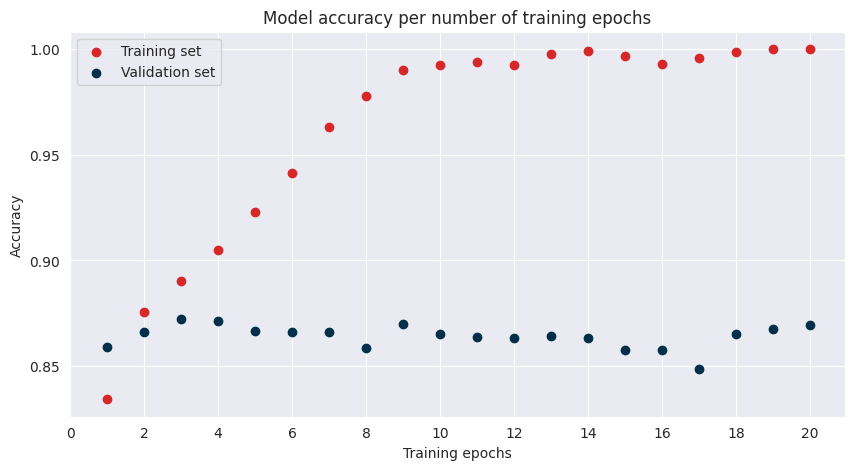

In [20]:
# Plot the model accuracy per training epoch in training and validation data

# Create a subplot
fig, ax = plt.subplots(figsize=(10,5))

# Plot the data as a scatter plot, specify data labels for legend
ax.scatter(range(1, EPOCHS+1), history.history['categorical_accuracy'], color=my_palette[0], label='Training set')
ax.scatter(range(1, EPOCHS+1), history.history['val_categorical_accuracy'], color=my_palette[1], label='Validation set')

# Set plot title text and location
ax.set_title('Model accuracy per number of training epochs')

# Clean up x- and y-axes
ax.set(xlabel='Training epochs')
ax.set(ylabel='Accuracy')
ax.locator_params(axis='y', nbins=6)
ax.set_xticks(np.linspace(0, 20, 11).astype(int))

# Add a legend
ax.legend()

# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'train-val-accuracy.pdf'), bbox_inches='tight');

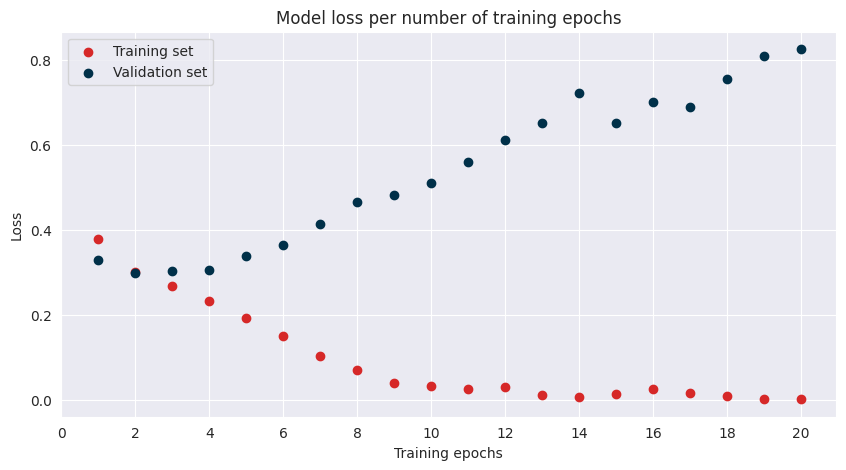

In [21]:
# Plot the model's loss per training epoch in training and validation data

# Create a subplot
fig, ax = plt.subplots(figsize=(10,5))

# Plot the data as a line, specify data labels for legend
ax.scatter(range(1, EPOCHS+1), history.history['loss'], color=my_palette[0], label='Training set')
ax.scatter(range(1, EPOCHS+1), history.history['val_loss'], color=my_palette[1], label='Validation set')

# Format the plots here

# Set plot title text and location
ax.set_title('Model loss per number of training epochs')

# Clean up x- and y-axes
ax.set(xlabel='Training epochs')
ax.set(ylabel='Loss')
ax.locator_params(axis='y', nbins=6)
ax.set_xticks(np.linspace(0, 20, 11).astype(int))

# Add a legend
ax.legend();

# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'train-val-loss.pdf'), bbox_inches='tight');

- We can see the model accuracy improve in training data with each epoch before plateauing at around epoch 11
- The model accuracy with the validation set peaks at 3 epochs and then gradually declines
- This implies that there is strong bias toward training data in the model after 3 or so training epochs
- Likewise, looking at the loss after each epoch, we see that in training it continues to decrease (output more closely matches labels), while in the validation set the loss dips at 3 epochs and then continues to increase with more training epochs, further indicating that the model suffers from training bias after 3 epochs
- Therefore the best performing model is the one trained on 3 epochs
- Let's see how this model performs with the testing dataset we set aside

# Model Evaluation

- Time to evaluate our model
- Load the model state (weights and biases) saved after 3 training epochs back into the model

In [14]:
# Load the saved model weights and biases
best_model_filepath = '/kaggle/working/models/model_checkpoint_epoch03.keras'
model.load_weights(best_model_filepath)

# Evaluate the model with the testing dataset
model.evaluate(test_input, test_labels, batch_size=BATCH_SIZE)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - categorical_accuracy: 0.8748 - loss: 0.3108


[0.31546667218208313, 0.8702499866485596]

- Evaluating the model (trained with 4 epochs) with the test dataset returned an accuracy of 87.5 % which closely matches the accuracy of the validation set during training (88%)
- While not perfect, a testing accuracy of 87% shows that this is a particularly well-performing model!
- Now let's get the model's predictions with the training and testing sets for further evaluation

In [15]:
# Get the predictions with our model for training and testing sets
train_pred = model.predict(train_input, batch_size=BATCH_SIZE)
test_pred = model.predict(test_input, batch_size=BATCH_SIZE)

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


- Now add the predictions back into the training and testing (split and shuffled) dataframes

In [16]:
# Load the predictions into new dataframes (one for training one for testing)
df_train_pred = pd.DataFrame(train_pred, columns=['pos_pred', 'neg_pred'])
df_test_pred = pd.DataFrame(test_pred, columns=['pos_pred', 'neg_pred'])

# Add predictions as columns to training/testing dataframes
# The ordering of the predictions still matches the original shuffled train/test datasets if we convert to a list
df_train['pos_pred'] = list(df_train_pred['pos_pred'])
df_train['neg_pred'] = list(df_train_pred['neg_pred'])
df_test['pos_pred'] = list(df_test_pred['pos_pred'])
df_test['neg_pred'] = list(df_test_pred['neg_pred'])

# Now add the predicted sentiment label, based on a prediction threshold of 0.5
df_train['pred_label'] = np.where(df_train['pos_pred'] > 0.5, 'positive', 'negative')
df_test['pred_label'] = np.where(df_test['pos_pred'] > 0.5, 'positive', 'negative')

# Verify the size and data-types of the df
df_train.info()
df_test.info()

# Verify the first few rows
df_train.head()
df_test.head()


<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 17815 to 2732
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stars            16000 non-null  int64  
 1   lemmatized_text  16000 non-null  object 
 2   word_embeddings  16000 non-null  object 
 3   onehot_label     16000 non-null  object 
 4   label            16000 non-null  object 
 5   pos_pred         16000 non-null  float64
 6   neg_pred         16000 non-null  float64
 7   pred_label       16000 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 19134 to 8781
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stars            4000 non-null   int64  
 1   lemmatized_text  4000 non-null   object 
 2   word_embeddings  4000 non-null   object 
 3   onehot_label     4000 non-null  

,stars,lemmatized_text,word_embeddings,onehot_label,label,pos_pred,neg_pred,pred_label
17815,5,"[come, California, hard, find, authentic, mexi...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive,0.986710,0.013290,positive
18370,5,"[amazing, bit, emergency, need, lot, work, spi...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive,0.997039,0.002961,positive
1379,4,"[look, different, area, highly, recommend, Glo...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive,0.786467,0.213533,positive
14763,5,"[great, experience, walk, order, food, take, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive,0.998127,0.001873,positive
7346,3,"[service, horrible, man, eye, contact, take, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative,0.082500,0.917500,negative


,stars,lemmatized_text,word_embeddings,onehot_label,label,pos_pred,neg_pred,pred_label
19134,3,"[food, consistent, try, OSFs, WA, good, reason...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative,0.272319,0.727681,negative
4981,4,"[Bailey, range, great, product, Mr., Bailey, c...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive,0.991859,0.008141,positive
16643,1,"[slow, pharmacy, see, line, 6, 7, deep, pick, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative,0.081210,0.918790,negative
19117,2,"[Philly, participate, recent, Philadelphia Mar...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0]",negative,0.236149,0.763851,negative
5306,4,"[fun, Friday, night, come, Saturday, bartender...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0]",positive,0.964487,0.035513,positive


- It is helpful to look at the distribution of prediction values (probabilities) for each class to see how "confident" the model is in predicting each class

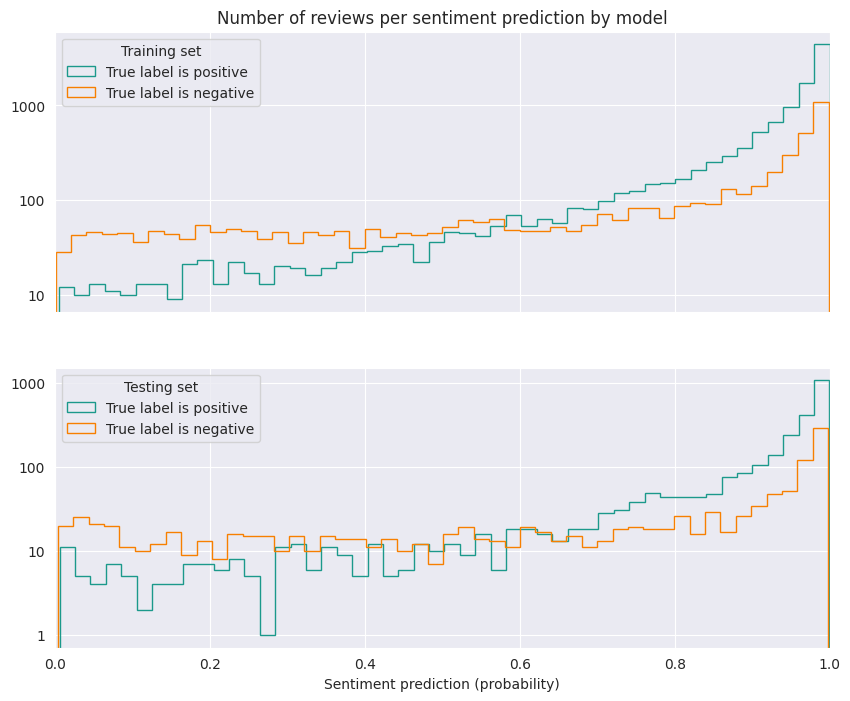

In [22]:
# Plot the distribution of predictions (probabilities) for positive and negative sentiment data

# Create subplots with 2 rows
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,8))

# Plot the data as step histograms with 50 bins, a log-scale y-axis, and specify data labels for legend
# Training data
df_train.loc[df_train['label'] == 'positive']['pos_pred'].plot(kind='hist', histtype=u'step', bins=50, log=True, color=my_palette[2], label='True label is positive', ax=ax[0]) # positive data
df_train.loc[df_train['label'] == 'negative']['neg_pred'].plot(kind='hist', histtype=u'step', bins=50, log=True, color=my_palette[3], label='True label is negative', ax=ax[0]) # negative data

# Testing data
df_test.loc[df_test['label'] == 'positive']['pos_pred'].plot(kind='hist', bins=50, histtype=u'step', log=True, color=my_palette[2], label='True label is positive', ax=ax[1]) # positive data
df_test.loc[df_test['label'] == 'negative']['neg_pred'].plot(kind='hist', bins=50, histtype=u'step', log=True, color=my_palette[3], label='True label is negative', ax=ax[1]) # negative data

# Set plot title
ax[0].set_title('Number of reviews per sentiment prediction by model')

# Clean up x- and y-axes
ax[1].set_xlabel('Sentiment prediction (probability)')
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)
ax[0].yaxis.set_major_formatter(ScalarFormatter())
ax[1].yaxis.set_major_formatter(ScalarFormatter())

# Add legends
ax[0].legend(title='Training set')
ax[1].legend(title='Testing set')

# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'sentiment-predictions.pdf'), bbox_inches='tight');

- The distributions are strongly peaked toward a prediction probability of 1.0, indicating that the model performs well for both classes and on both datasets 
- There are more negative reviews predicted with low probability than there are positive (in the left tails), and vis versa for predictions with high probability (right peaks), indicating that the model performs better on positive reviews than negative
- This is expected as the data were biased toward posititve reviews

## Class accuracy, error, and confusion matrix

- We can turn our model into a binary classifier by assigning a review to the class that recieves a prediction greater than 0.5 (this was done automatically by Keras when computing the training, validation, and evaluation accuracies)
- Using this threshold we can compute the accuracy and error for each class, and a confusion matrix

Model accuracy: 87.02%
Model error: 12.97%


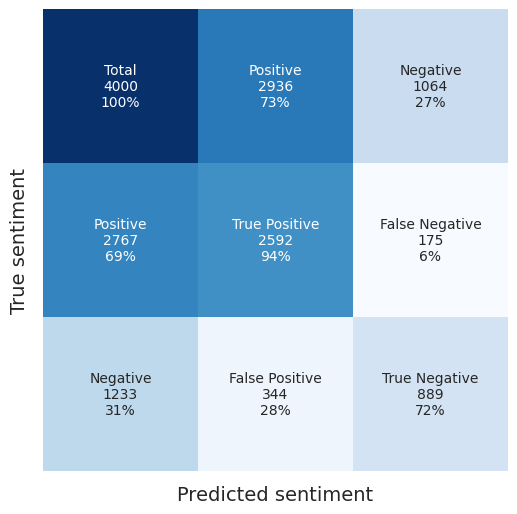

In [18]:
# Confusion matrix, accuracy, and erro for testing data

T = len(df_test) # total count (P + N)
P = len(df_test.loc[df_test['label'] == 'positive']) # Ground truth positive count
N = len(df_test.loc[df_test['label'] == 'negative']) # Ground truth negative count
PP = len(df_test.loc[df_test['pred_label'] == 'positive']) # Predicted positive count
PN = len(df_test.loc[df_test['pred_label'] == 'negative']) # Predicted negative count
TP = len(df_test.loc[(df_test['pred_label'] == 'positive') & (df_test['label'] == 'positive')]) # True positive count
FP = len(df_test.loc[(df_test['pred_label'] == 'positive') & (df_test['label'] == 'negative')]) # False positive count
TN = len(df_test.loc[(df_test['pred_label'] == 'negative') & (df_test['label'] == 'negative')]) # True negative count
FN = len(df_test.loc[(df_test['pred_label'] == 'negative') & (df_test['label'] == 'positive')]) # False negative count

T_rate = T/T # total rate (1.0)
P_rate = P/T # Grount truth positive rate
N_rate = N/T # Ground truth negative rate
PP_rate = PP/T # Predicted positive rate
PN_rate = PN/T # Predicted negative rate
TP_rate = TP/P # True positive rate
FP_rate = FP/N # False positive rate
TN_rate = TN/N # True negative rate
FN_rate = FN/P # False negative rate

# Confusion matrix of counts
confusion_matrix_counts = np.array([[T, PP, PN],
                                    [P, TP, FN],
                                    [N, FP ,TN]])

# Confusion matrix of rates
confusion_matrix_rates = np.array([[T_rate, PP_rate, PN_rate],
                                   [P_rate, TP_rate, FN_rate],
                                   [N_rate, FP_rate, TN_rate]])

# Let's also look at the accuracy and error for each class
T_acc = (TP+TN)/T # Total accuracy
T_err = (FP+FN)/T # Total error rate

# Print accuracy and errors
print(f'Model accuracy: {100*T_acc:.2f}%')
print(f'Model error: {100*T_err:.2f}%')

# Plot the confusion matrix of counts/rates

# Get the labels for each square
cm_names = ['Total', 'Positive', 'Negative', 'Positive', 'True Positive', 'False Negative', 'Negative', 'False Positive', 'True Negative']
cm_counts = [f'{count}' for count in confusion_matrix_counts.flatten()]
cm_rates = [f'{100*rate:.0f}%' for rate in confusion_matrix_rates.flatten()]
cm_labels = [ f'{name}\n{count}\n{rate}' for name, count, rate in zip(cm_names, cm_counts, cm_rates)]
cm_labels = np.asarray(cm_labels).reshape(3,3)

# Create a subplot
f, ax = plt.subplots(figsize=(6,6))

# Plot as a heatmap with annotations/values inside each square, with no sidebar
sns.heatmap(confusion_matrix_counts, annot=cm_labels, cmap='Blues', fmt='', cbar=False)

# Do not display x- and y-axis ticks/values
ax.set_xticks([])
ax.set_yticks([])

# Set the x- and y-axis labels
ax.set_xlabel('Predicted sentiment', labelpad=10, fontsize=14, loc='center')
ax.set_ylabel('True sentiment', labelpad=10, fontsize=14, loc='center')

# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'confusion-matrix.pdf'), bbox_inches='tight');

- The model accuracy on test documents with positive sentiment is 94% while the error rate is 6%
- The model accuracy on test documents with negative sentiment is 72% while the error rate is 28%
- The model accuracy on test documents of any sentiment is 87% while the error rate is 13% (consistent with the Keras evaluate method)

# Word Cloud

- As a final sanity-check, let's make a word cloud for all the text in each class prediction and see if this matches what we might expect

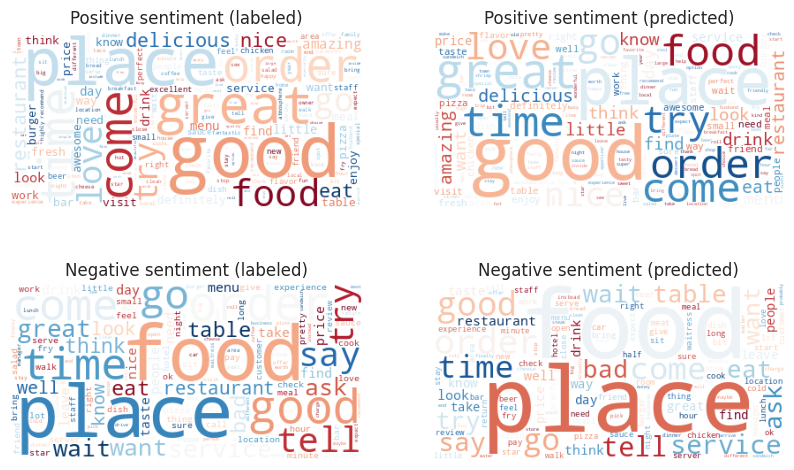

In [19]:
# Join all the text into one string for each subset
text_pred_pos = ' '.join([' '.join(word) for word in list(df_test.loc[df_test['pred_label'] == 'positive']['lemmatized_text'])])
text_pred_neg = ' '.join([' '.join(word) for word in list(df_test.loc[df_test['pred_label'] == 'negative']['lemmatized_text'])])
text_label_pos = ' '.join([' '.join(word) for word in list(df_test.loc[df_test['label'] == 'positive']['lemmatized_text'])])
text_label_neg = ' '.join([' '.join(word) for word in list(df_test.loc[df_test['label'] == 'negative']['lemmatized_text'])])

# Create the word clouds for each subset
wc_pred_pos = WordCloud(background_color='white', colormap = 'RdBu').generate(text_pred_pos)
wc_pred_neg = WordCloud(background_color='white', colormap = 'RdBu').generate(text_pred_neg)
wc_label_pos = WordCloud(background_color='white', colormap = 'RdBu').generate(text_label_pos)
wc_label_neg = WordCloud(background_color='white', colormap = 'RdBu').generate(text_label_neg)

# Plotting

# Creat 4 subplots
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(10, 6))

# Plot the word clouds
ax[0,0].imshow(wc_label_pos)
ax[0,1].imshow(wc_pred_pos)
ax[1,0].imshow(wc_label_neg)
ax[1,1].imshow(wc_pred_neg)

# Set subplot titles text and location
ax[0,0].set_title('Positive sentiment (labeled)', loc='center')
ax[0,1].set_title('Positive sentiment (predicted)', loc='center')
ax[1,0].set_title('Negative sentiment (labeled)', loc='center')
ax[1,1].set_title('Negative sentiment (predicted)', loc='center')

# Turn off the axes
ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")

# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'word-cloud.pdf'), bbox_inches='tight');

- The word clouds show that the most frequent words do not vary much between predicted and actual labels
- It is very clear that the positive sentiment includes words we would expect, like "good," "love," "amazing," and "delicious"
- The negative sentiment is harder to interpret---we still see expected words like "bad," and "wait,"---but we see more neutral than negative, like "food," "place," "service," and even positive words like "good"
- However, this makes some sense, as we included 3 star reviews in the negative class which could be seen as more neutral than negative, and even 1 and 2 star reviews may not carry as strong a sentiment as the positive reviews (despite being associated with such a low star rating)
- Also, there is far fewer data in the negative class than the positive which can impact these results

# Discussion

Overall this project was a great success! The best model is able to achieve an overall accuracy of 88% which is decent performance given the training sample size and the limitations introduced by training on Yelp business reviews. In order to improve the model, several steps could be taken. 
1. Take a larger sample from the original dataset. I only used a small fraction to expidite the analysis, but given more time and memory resources I believe more training samples would improve the model accuracy. Also, selecting a subset with a uniform distribution of positive and negative sentiment would remove the heavy bias toward positive sentiment, if that was of interest. 
2. More fine tuning of the NLP. For example, using a larger corpus for the word2vec training or increasing the size of the word embeddings. 
3. Fine tune the model and training parameters. While I optimized on the number of training epochs, other parameters could be batch size and step size when finding the loss function minima. Also, I could experiment with other optimization algorithms and loss functions, although the Adam optimizer and cross-entropy are usually well suited for this type of task. For the model, the number of recurrent layers could potentially be optimized, along with the fully-connected layers. 
4. Changing the class definitions. I could experiment with how many stars are associated with each class, or even introduce a neutral class. This comes with additional challenges, and I think Yelp reviews are not the best source of text for that level of nuance. 
5. Removing high-frequency neutral words. As I noticed with the word clouds, both classes were still mostly neutral in tone. The words "place," "food," and "time" all appeared with very high frequency in all reviews. Removing these words from the text (like stop words) could potentially improve the performance of the model.
6. Finally, and what I think would offer the greatest improvement, is improve the data source and quality. Yelp reviews are not as well written as published text like Wikipedia, journals, books, etc., and include lots of typos, misspellings, odd/repeated punctuation, etc., which can confuse the spaCy NLP model. Better data cleaning can help but there will always be limits. The limited context of a Yelp review means there is not much variation in the content of the texts (this is most obvious when looking at the word clouds). For example, sentiment will almost exclusively involve either food taste, wait times, or service quality, which will bias the model. A corpus with a greater scope could result in a better model, e.g., IMDB movie reviews or Twitter/X tweets.